# Homework 03 - Classification

## Preparations

The data set `bank-full.csv` has been downloaded previous week already.

### Dependencies

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Load and Prepare Data

In [2]:
# define path to data
PATH_DATA = Path("../data/bank_marketing/bank/bank-full.csv")

# read data
data_bank_full = pd.read_csv(PATH_DATA, sep=";")
data_bank_full

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
# not all columns are used in exercise
# select those that are

# make list containing used columns
feature_columns = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
]

# select features from full data
X = data_bank_full[feature_columns]

# select labels from full data
y = data_bank_full["y"]

In [4]:
# get full train and test sets from full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
# get train and validation sets from full train set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Question 1

Compare these features regarding their importance using AUROC:

```
balance
day
duration
previous
```

In [6]:
# define a list of the features to compare
features_compare_importance = [
    "balance",
    "day",
    "duration",
    "previous"
]

# define function for calculating AUROC as feature importance
def auroc_feature_importance(feature, X_t=X_train, y_t=y_train):

    # calculate AUROC
    auroc_feature = roc_auc_score(y_true=y_t, y_score=X_t[feature])
    
    # check if AUROC is less than 0.5
    # if yes, invert variable to get feature importance
    # then calculate again
    if auroc_feature < 0.5:
        y_score = -X_t[feature]
        auroc_feature = roc_auc_score(y_true=y_t, y_score=y_score)
    
    # pack feature name and AUROC result into one tuple
    result_comparison = (feature, auroc_feature)
    
    return result_comparison
    
    
# iterate through the list and get AUROC for each of the features
for feature in features_compare_importance:
    print(auroc_feature_importance(feature=feature))

('balance', np.float64(0.5888313805382317))
('day', np.float64(0.525957882383908))
('duration', np.float64(0.8147002759670778))
('previous', np.float64(0.5985653242764153))


The feature `duration` has the highest AUC.

## Question 2

In [7]:
# apply one-hot-encoding to the features of the data sets
X_train = pd.get_dummies(X_train, dtype=int)
X_val = pd.get_dummies(X_val, dtype=int)
X_test = pd.get_dummies(X_test, dtype=int)

# encode label numerically so AUROC can be calculated
y_val_numeric = np.where(y_val == 'yes', 1, 0)

In [8]:
# define a logistic regression model
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)

# fit the model to the train data set
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
# get prediction probabilities from the trained model
y_pred_val = model.predict_proba(X_val)[:, 1]
y_pred_val

array([0.02900326, 0.02263738, 0.02102469, ..., 0.24560689, 0.0022598 ,
       0.03800144])

In [10]:
# calculate AUROC of the trained model on the validation data set
AUROC_val = roc_auc_score(y_true=y_val_numeric, y_score=y_pred_val)
AUROC_val = round(AUROC_val, ndigits=3)
AUROC_val

np.float64(0.9)

The AUROC is 0.9 in my case, which does not match any of the multiple choice answers exactly.
The closest one is 0.89.

## Question 3

In [11]:
# predict probabilities, not decisions
# this is necessary for determining decisions and thus precision & recall at different thresholds
probas_sklearn = model.predict_proba(X_val)[:, 1]

In [12]:
# use sklearns function for computing precision and recall curves at 
precision, recall, thresholds = precision_recall_curve(y_true=y_val_numeric, y_score=probas_sklearn)

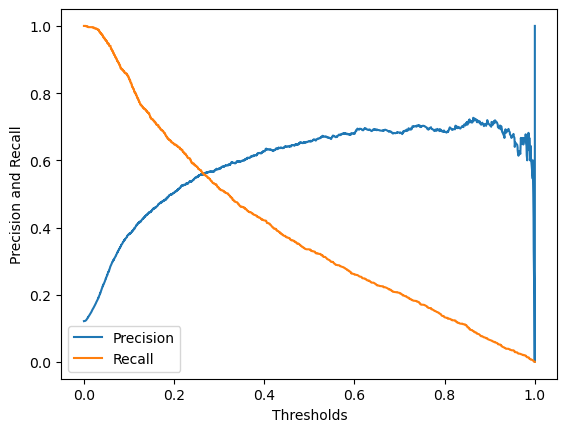

In [13]:
# plot precision and recall against the thresholds
# I removed the very first entry, because dimensions didn't match 
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Thresholds")
plt.ylabel("Precision and Recall")
plt.legend()

In [14]:
# find intersection of precision and recall
# get point at which precision and recall are equal
intersection = precision[1:] == recall[1:]

# get the thresholds at which precision and recall are equal
thresholds[intersection]

array([0.26585033, 0.99937009, 0.99984114, 0.99992475, 0.99998678])

Precision and recall intersect at 0.266. For this exercise, I will not consider what's happening with precision close to 1.

## Question 4

Formula for F1 score is:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Both `precision` and `recall` are numpy arrays in my case, so they can be broadcasted.

In [15]:
# calculate F1 score
f1_score = 2 * precision * recall / (precision + recall)

/var/folders/mk/sqk63g391x1cj_llvqsv9xfmkb6y8r/T/ipykernel_12221/2004878096.py:2: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)


In [16]:
# this includes division by zero, so it contains several nan or rather missing values
# handle these by converting them to zero
f1_score = np.nan_to_num(f1_score)

In [17]:
# get maximal F1 score
max_f1 = f1_score.max()

# get index of maximum F1 score
index_max_f1 = np.where(f1_score == max_f1)

# get corresponding threshold
threshold_max_f1 = np.round(thresholds[index_max_f1], 3)
threshold_max_f1

array([0.218])

The F1 score is maximal when the threshold is equal to about 0.218. The closest result from the multiple choice is 0.22.

## Question 5

In [18]:
# concatenate train and validation sets to full train set
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

In [19]:
# define function for full train and evaluation run
def train_and_evaluate_auroc(X, y, train_IDs, val_IDs, C):
    # get features
    features_train = X.iloc[train_IDs]
    features_val = X.iloc[val_IDs]
    
    # get labels
    labels_train = y.iloc[train_IDs]
    labels_val = y.iloc[val_IDs]
    labels_val_numeric = np.where(labels_val == "yes", 1, 0)
    
    # define and fit model
    model_kfold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model_kfold.fit(features_train, labels_train)
    
    # predict probabilities, get those of positive class
    probas_val = model_kfold.predict_proba(features_val)[:, 1]
    
    # calculate auroc and append to score list
    auc = roc_auc_score(y_true=labels_val_numeric, y_score=probas_val)
    
    return auc

# define kfold generator with 5 splits
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [20]:
# define empty list to contain results
scores = []

# compute kfold validation
# iterate through all split variants
for train_idx, val_idx in kfold.split(X_train_full):
    
    # get the auroc for the current split
    auc = train_and_evaluate_auroc(X=X_train_full, y=y_train_full, train_IDs=train_idx, val_IDs=val_idx, C=1.0)

    # append result to the scores list
    scores.append(auc)

In [21]:
# calculate mean and standard deviation
mean_auroc_kfold = np.mean(scores)
std_auroc_kfold = np.std(scores)

# print result
print("mean:", round(mean_auroc_kfold, 3), "std:", round(std_auroc_kfold, 3))

mean: 0.906 std: 0.005


The standard deviation of the AUROC scores across different folds is about 0.005, which is closest to 0.006.

## Question 6


In [22]:
# define list of regularization parameter values to be tested
C_list = [0.000001, 0.001, 1]

In [23]:
# iterate through the three regularization parameter values^
for C in C_list:
    
    # define empty list to contain results
    scores = []

    # compute kfold validation
    for train_idx, val_idx in kfold.split(X_train_full):
        
        # get the auroc for the current split
        auc = train_and_evaluate_auroc(X=X_train_full, y=y_train_full, train_IDs=train_idx, val_IDs=val_idx, C=C)

        # append result to the scores list
        scores.append(auc)
    
    # print results
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.005
C=0.001 0.861 +- 0.005
C=1 0.906 +- 0.005


If C=1, the mean is 0.906, which is the highest of all three tested regularization parameter values.
So, the answer to this question is: `1`.